In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle, math, datetime
from pprint import pformat
from graphviz import Digraph
from itertools import combinations
from scipy.interpolate import interp1d
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from confusion_matrix_pretty_print import pretty_plot_confusion_matrix


import hmms
import os
import math

In [2]:
# Configuration parameters
N_nodes = 81
random_state = 1
val_size = 1/3
K = 3
# rejection_negative_bias = 0
# pbl_negative_bias = 0
# pbr_negative_bias = 0
# rotl_negative_bias = 0
# rotr_negative_bias = 0
# pc_negative_bias = 0
rejection_negative_bias = 0
pbl_negative_bias = 2
pbr_negative_bias = 0
rotl_negative_bias = 0
rotr_negative_bias = 0
pc_negative_bias = 0

rejections_trained = True
# baum_welch = True
# bw_epochs = 10

# Observation matrix params
prob_emission_equals_hidden = 0.95

prob_emission_not_equals_hidden = 1 - prob_emission_equals_hidden

#Trans prob matrix params
trans_prob_factor = 100
rejection_trans_prob_factor = 1

#Init prob matrix params
init_prob_factor = 100
rejection_init_prob_factor = 1

In [3]:
# Load validation QTC_C sequences (recorded in lab)
rotl_lab_seqs = []
rotr_lab_seqs = []
pb_l_lab_seqs = []
pb_r_lab_seqs = []
pc_lab_seqs = []
u_lab_seqs = []
u_lab_seqs_no_train = []

with open("study_qtc_seqs.pickle", "rb") as f:
    lab_seqs = pickle.load(f)
lab_seqs

{'pcr_4': ['+--+',
  '+--0',
  '+--+',
  '+--0',
  '+---',
  '+0--',
  '++0-',
  '++--',
  '++0-',
  '++0+'],
 'rotl_10': ['+0-0',
  '+---',
  '+0--',
  '+0-0',
  '++-0',
  '++--',
  '+0--',
  '+---',
  '+0--',
  '++--',
  '++-0',
  '+0-+',
  '+--0',
  '+0-0',
  '+0--',
  '++--',
  '++0-',
  '++-0',
  '+000',
  '+00-',
  '++0-',
  '++00',
  '++0-',
  '+00-',
  '++0-'],
 'rotl_11': ['+0-0',
  '+---',
  '+0-0',
  '++-0',
  '++--',
  '+0--',
  '+---',
  '+0--',
  '++--',
  '+0--',
  '++--',
  '++-0',
  '++--',
  '+0--',
  '++--',
  '+0--',
  '++--',
  '++0-',
  '+00-',
  '++0-',
  '++00',
  '+000',
  '0-00',
  '0-0+',
  '000+',
  '0-0+',
  '0-00'],
 'rotl_12': ['+---',
  '+0--',
  '+0-0',
  '+0--',
  '++--',
  '+0--',
  '++-0',
  '++--',
  '+0--',
  '+--0',
  '+00-',
  '+0-0',
  '+000',
  '++00',
  '++0-',
  '+00-',
  '++0-',
  '++00',
  '++0-',
  '+00-',
  '++0-',
  '++00'],
 'pbl_10': ['+---', '+0--', '++--', '++0-', '+++-', '+-+-', '+-+0'],
 'pbl_11': ['0---', '+---', '+0--', '++--', '

In [4]:
for key in lab_seqs.keys():
    class_code = key.split("_")[0]
    
    if key.split("_")[0] == "rotl":
        rotl_lab_seqs.append(lab_seqs[key])
    elif key.split("_")[0] == "rotr":
        rotr_lab_seqs.append(lab_seqs[key])
    elif "pb" in class_code:
        if "l" in class_code:
            pb_l_lab_seqs.append(lab_seqs[key])
        else:
            pb_r_lab_seqs.append(lab_seqs[key])
    elif "pc" in class_code:
        pc_lab_seqs.append(lab_seqs[key])
    else:
        u_lab_seqs.append(lab_seqs[key])
        
print(len(rotl_lab_seqs))
print(len(rotr_lab_seqs))
print(len(pb_l_lab_seqs))
print(len(pb_r_lab_seqs))
print(len(pc_lab_seqs))
print(len(u_lab_seqs))

11
10
11
11
21
11


In [5]:
with open("controlled_lab_qtc_seqs.pickle", "rb") as f:
    e_lab_seqs = pickle.load(f)
e_lab_seqs

{'ot_hotr_12': ['+-0+', '+--+', '++--'],
 'u_h_pb_l_robot_stationary_8': ['0-0-', '0+0-', '0+0+', '0+00'],
 'ot_hotl_6': ['+-+0',
  '+-+-',
  '+-+0',
  '+-++',
  '+-0+',
  '+--+',
  '+0-+',
  '+---',
  '++--',
  '++-+',
  '++--',
  '++0-'],
 'ot_rotl_33': ['+0--',
  '++--',
  '+0--',
  '+---',
  '+0--',
  '++--',
  '+0-0',
  '+0--',
  '++--',
  '++-0',
  '++--',
  '+---',
  '++--',
  '+0--',
  '++--',
  '++-0',
  '++--',
  '+000',
  '+-00',
  '+000',
  '+00+',
  '0-0+'],
 'pc_r_23': ['--00',
  '--0+',
  '--00',
  '--0+',
  '--00',
  '--0-',
  '----',
  '-0--',
  '0+--'],
 'pc_r_35': ['--+0', '--+-', '--+0', '--+-', '--+0', '--+-', '--+0', '--+-'],
 'pc_r_34': ['--++', '--+0', '--++', '--+-', '--+0', '--+-', '--++'],
 'pc_r_31': ['--+0', '--++', '--+0', '--++', '--+-', '--+0', '--+-'],
 'pc_r_30': ['--0+', '--++', '--+0', '--+-', '--+0'],
 'pc_r_33': ['--+0',
  '--++',
  '--+0',
  '--+-',
  '--+0',
  '--++',
  '--+-',
  '--+0',
  '--+-',
  '--+0',
  '--+-',
  '--+0'],
 'pc_r_32': ['--++

In [6]:
rotl_e_lab_seqs = []
rotr_e_lab_seqs = []
pb_l_e_lab_seqs = []
pb_r_e_lab_seqs = []
pc_l_e_lab_seqs = []
pc_r_e_lab_seqs = []
h_and_r_stationary_e_lab_seqs = []
h_meets_stationary_r_e_lab_seqs = []
h_pb_l_robot_stationary_e_lab_seqs = []
h_pb_r_robot_stationary_e_lab_seqs = []
r_meets_stationary_h_e_lab_seqs = []

for key in e_lab_seqs.keys():
    print(key)
    class_code = key.split("_")[0]
    
    if "rotl" in key:
        rotl_e_lab_seqs.append(e_lab_seqs[key])
    elif "rotr" in key:
        rotr_e_lab_seqs.append(e_lab_seqs[key])
    elif "pb" in class_code:
        if "l" in key:
            pb_l_e_lab_seqs.append(e_lab_seqs[key])
        else:
            pb_r_e_lab_seqs.append(e_lab_seqs[key])
    elif "pc" in class_code:
        if "l" in key:
            pc_l_e_lab_seqs.append(e_lab_seqs[key])
        else:
            pc_r_e_lab_seqs.append(e_lab_seqs[key])
    else:
        if "h_and_r_stationary" in key:
            h_and_r_stationary_e_lab_seqs.append(e_lab_seqs[key])
        elif "h_meets_stationary_r" in key:
            h_meets_stationary_r_e_lab_seqs.append(e_lab_seqs[key])
        elif "h_pb_l_robot_stationary" in key:
            h_pb_l_robot_stationary_e_lab_seqs.append(e_lab_seqs[key])
        elif "h_pb_r_robot_stationary" in key:
            h_pb_r_robot_stationary_e_lab_seqs.append(e_lab_seqs[key])
        elif "r_meets_stationary_h" in key:
            r_meets_stationary_h_e_lab_seqs.append(e_lab_seqs[key])

ot_hotr_12
u_h_pb_l_robot_stationary_8
ot_hotl_6
ot_rotl_33
pc_r_23
pc_r_35
pc_r_34
pc_r_31
pc_r_30
pc_r_33
pc_r_32
ot_rotl_24
ot_rotl_25
ot_rotl_26
ot_rotl_27
ot_rotl_20
ot_rotl_21
ot_rotl_22
ot_rotl_23
u_r_meets_stationary_h_13
ot_rotl_28
ot_rotl_29
ot_rotl_35
pc_r_25
ot_rotr_13
ot_rotr_12
ot_rotr_11
ot_rotr_10
ot_rotr_17
ot_rotr_16
ot_rotr_15
ot_rotr_14
ot_rotr_19
ot_rotr_18
pb_l_18
pc_r_28
pb_l_19
u_h_pb_r_robot_stationary_6
u_h_pb_r_robot_stationary_7
u_h_pb_l_robot_stationary_6
u_h_pb_l_robot_stationary_7
pc_r_22
pb_r_14
pc_r_20
pc_r_21
pc_r_26
pc_r_27
pc_r_24
pb_r_15
u_r_meets_stationary_h_12
pb_l_12
u_h_and_r_stationary_12
u_h_pb_r_robot_stationary_8
pc_l_14
u_h_meets_stationary_r_12
u_h_meets_stationary_r_13
u_h_meets_stationary_r_10
u_h_meets_stationary_r_11
pb_l_10
u_h_meets_stationary_r_14
u_h_meets_stationary_r_15
pc_l_16
ot_rotl_7
ot_rotl_6
ot_rotl_9
pb_l_16
u_h_and_r_stationary_9
pb_l_17
pc_l_9
pc_l_8
ot_rotr_9
ot_rotr_8
pb_l_14
pc_l_12
ot_rotr_7
ot_rotr_6
pc_l_7
pc_l_6


In [7]:
# rotl_e_lab_seqs = shuffle(rotl_e_lab_seqs, random_state=random_state)
# rotr_e_lab_seqs = shuffle(rotr_e_lab_seqs, random_state=random_state)
# pb_l_e_lab_seqs = shuffle(pb_l_e_lab_seqs, random_state=random_state)
# pb_r_e_lab_seqs = shuffle(pb_r_e_lab_seqs, random_state=random_state)
# pc_l_e_lab_seqs = shuffle(pc_l_e_lab_seqs, random_state=random_state)
# pc_r_e_lab_seqs = shuffle(pc_r_e_lab_seqs, random_state=random_state)
# h_and_r_stationary_e_lab_seqs = shuffle(h_and_r_stationary_e_lab_seqs, random_state=random_state)
# h_meets_stationary_r_e_lab_seqs = shuffle(h_meets_stationary_r_e_lab_seqs, random_state=random_state)
# h_pb_l_robot_stationary_e_lab_seqs = shuffle(h_pb_l_robot_stationary_e_lab_seqs, random_state=random_state)
# h_pb_r_robot_stationary_e_lab_seqs = shuffle(h_pb_r_robot_stationary_e_lab_seqs, random_state=random_state)
# r_meets_stationary_h_e_lab_seqs = shuffle(r_meets_stationary_h_e_lab_seqs, random_state=random_state)

# rotl_lab_seqs.append(rotl_e_lab_seqs[0])
# rotr_lab_seqs.append(rotr_e_lab_seqs[0])
# pb_l_lab_seqs.append(pb_l_e_lab_seqs[0])
# pb_r_lab_seqs.append(pb_r_e_lab_seqs[0])
# pc_lab_seqs.append(pc_l_e_lab_seqs[0])
# pc_lab_seqs.append(pc_r_e_lab_seqs[0])
# u_lab_seqs.append(h_and_r_stationary_e_lab_seqs[0])
# u_lab_seqs.append(h_meets_stationary_r_e_lab_seqs[0])
# u_lab_seqs.append(h_pb_l_robot_stationary_e_lab_seqs[0])
# u_lab_seqs.append(h_pb_r_robot_stationary_e_lab_seqs[0])
# u_lab_seqs.append(r_meets_stationary_h_e_lab_seqs[0])

In [8]:
# for key in lab_seqs.keys():
#     class_code = key.split("_")[0]
    
#     if key.split("_")[1] == "rotl":
#         rotl_lab_seqs.append(lab_seqs[key])
#     elif key.split("_")[1] == "rotr":
#         rotr_lab_seqs.append(lab_seqs[key])
#     elif class_code == "pb":
#         if key.split("_")[1] == "l":
#             pb_l_lab_seqs.append(lab_seqs[key])
#         else:
#             pb_r_lab_seqs.append(lab_seqs[key])
#     elif class_code == "pc":
#         pc_lab_seqs.append(lab_seqs[key])
# #     elif "u_r_meets" in key or "u_h_meets" in key:
# #         u_lab_seqs_no_train.append(lab_seqs[key])
#     else:
#         u_lab_seqs.append(lab_seqs[key])
        
# print(len(rotl_lab_seqs))
# print(len(rotr_lab_seqs))
# print(len(pb_l_lab_seqs))
# print(len(pb_r_lab_seqs))
# print(len(pc_lab_seqs))
# print(len(u_lab_seqs))
# print(len(u_lab_seqs_no_train))

In [9]:
rotl_lab_seqs_train, rotl_lab_seqs_val = train_test_split(rotl_lab_seqs, 
    test_size=val_size,
    random_state=random_state)
print(len(rotl_lab_seqs_train))
print(len(rotl_lab_seqs_val))

7
4


In [10]:
rotr_lab_seqs_train, rotr_lab_seqs_val = train_test_split(rotr_lab_seqs, 
    test_size=val_size,
    random_state=random_state)
print(len(rotr_lab_seqs_train))
print(len(rotr_lab_seqs_val))

6
4


In [11]:
pb_l_lab_seqs_train, pb_l_lab_seqs_val = train_test_split(pb_l_lab_seqs, 
    test_size=val_size,
    random_state=random_state)
print(len(pb_l_lab_seqs_train))
print(len(pb_l_lab_seqs_val))

7
4


In [12]:
pb_r_lab_seqs_train, pb_r_lab_seqs_val = train_test_split(pb_r_lab_seqs, 
    test_size=val_size,
    random_state=random_state)
print(len(pb_r_lab_seqs_train))
print(len(pb_r_lab_seqs_val))

7
4


In [13]:
pc_lab_seqs_train, pc_lab_seqs_val = train_test_split(pc_lab_seqs, 
    test_size=val_size,
    random_state=random_state)
print(len(pc_lab_seqs_train))
print(len(pc_lab_seqs_val))

14
7


In [14]:
u_lab_seqs_train, u_lab_seqs_val = train_test_split(u_lab_seqs, test_size=val_size, random_state=random_state)
for seq in u_lab_seqs_no_train:
    u_lab_seqs_val.append(seq)
print(len(u_lab_seqs_train))
print(len(u_lab_seqs_val))

7
4


In [15]:
# Create list of QTC_C states so that indices can be used as integer state IDs compatible with HMM library
QTC_symbols = []
for i in range(0,4):
    QTC_symbols.append("-")
    QTC_symbols.append("0")
    QTC_symbols.append("+")
print("QTC symbols:", QTC_symbols[:3])
QTC_C_states = list(combinations(QTC_symbols, 4))
QTC_C_states = [state[0] + state[1] + state[2] + state[3] for state in QTC_C_states]
QTC_C_states = list(np.unique(QTC_C_states))
print("QTC_C states:\n", QTC_C_states)
print(len(QTC_C_states), "states total")

QTC symbols: ['-', '0', '+']
QTC_C states:
 ['++++', '+++-', '+++0', '++-+', '++--', '++-0', '++0+', '++0-', '++00', '+-++', '+-+-', '+-+0', '+--+', '+---', '+--0', '+-0+', '+-0-', '+-00', '+0++', '+0+-', '+0+0', '+0-+', '+0--', '+0-0', '+00+', '+00-', '+000', '-+++', '-++-', '-++0', '-+-+', '-+--', '-+-0', '-+0+', '-+0-', '-+00', '--++', '--+-', '--+0', '---+', '----', '---0', '--0+', '--0-', '--00', '-0++', '-0+-', '-0+0', '-0-+', '-0--', '-0-0', '-00+', '-00-', '-000', '0+++', '0++-', '0++0', '0+-+', '0+--', '0+-0', '0+0+', '0+0-', '0+00', '0-++', '0-+-', '0-+0', '0--+', '0---', '0--0', '0-0+', '0-0-', '0-00', '00++', '00+-', '00+0', '00-+', '00--', '00-0', '000+', '000-', '0000']
81 states total


In [16]:
def QTC_C_to_num(QTC_C):
    return QTC_C_states.index(QTC_C)


def QTC_C_seq_to_num_seq(QTC_C_seq):
    num_seq = []
    for QTC_C in QTC_C_seq:
        num_seq.append(QTC_C_to_num(QTC_C))

    return num_seq


def num_to_QTC_C(num):
    return QTC_C_states[num]


def num_seq_to_QTC_C_seq(num_seq):
    QTC_C_seq = []
    for num in num_seq:
        QTC_C_seq.append(num_to_QTC_C(num))

    return QTC_C_seq


print(QTC_C_to_num("++--"))
print(num_to_QTC_C(8))
print(num_seq_to_QTC_C_seq([0, 1, 2, 3]))
print(QTC_C_seq_to_num_seq(num_seq_to_QTC_C_seq([0, 1, 2, 3])))

4
++00
['++++', '+++-', '+++0', '++-+']
[0, 1, 2, 3]


In [17]:
# Defining a uniform transition matrix of N_nodes states
uniform_trans_mat = np.zeros((N_nodes, N_nodes))
uniform_trans_mat = np.array([[1/N_nodes for trans in row] for row in uniform_trans_mat])
print("\n", uniform_trans_mat)
row_sums = []
for row in uniform_trans_mat:
    row_sums.append(np.sum(row))
print(np.mean(row_sums))


 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]
1.0


In [18]:
def draw_transition_matrix(trans_matrix, filename, min_trans_prob):
    # draw its transition matrix
    dot = Digraph(comment='HMM model')
    col, row = trans_matrix.shape
    for i in range(0, col):
        for j in range(0, row):
#             print(i, j, trans_matrix[i, j])
            if trans_matrix[i, j] >= min_trans_prob:
#                 print(i, j, "is a high probability transition")
                dot.edge(num_to_QTC_C(i), num_to_QTC_C(j), label='{:2.2f}'.format(trans_matrix[i, j]))

    dot.render(filename, view=True)

## Creating pass-by left HMM

In [19]:
pass_by_l_seqs = pb_l_lab_seqs_train

In [20]:
pass_by_l_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_l_seqs]
print(pass_by_l_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pass_by_l_seqs]

[[67, 13, 22, 4, 7, 16, 15], [40, 67, 4, 7], [13, 22, 4, 7, 1, 10, 11], [13, 22, 4, 7], [40, 4, 5, 3, 4, 3, 5, 4, 12, 4], [23, 22, 4, 13, 4, 13, 4, 22, 4, 13, 4, 13, 4, 13, 4, 13, 22, 4], [67, 13, 4, 7, 16, 8]]


[['0---', '+---', '+0--', '++--', '++0-', '+-0-', '+-0+'],
 ['----', '0---', '++--', '++0-'],
 ['+---', '+0--', '++--', '++0-', '+++-', '+-+-', '+-+0'],
 ['+---', '+0--', '++--', '++0-'],
 ['----',
  '++--',
  '++-0',
  '++-+',
  '++--',
  '++-+',
  '++-0',
  '++--',
  '+--+',
  '++--'],
 ['+0-0',
  '+0--',
  '++--',
  '+---',
  '++--',
  '+---',
  '++--',
  '+0--',
  '++--',
  '+---',
  '++--',
  '+---',
  '++--',
  '+---',
  '++--',
  '+---',
  '+0--',
  '++--'],
 ['0---', '+---', '++--', '++0-', '+-0-', '++00']]

In [21]:
# Create transition matrix from handwritten examples of pass-by QTC-B sequences
# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pass_by_l_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
0
1
2
0
1
2
3
4
5
0
1
2
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.00552486 0.00552486 0.00552486 ... 0.00552486 0.00552486 0.00552486]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]


In [22]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())

# Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in pass_by_l_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

# print(Pi)
# print(Pi.sum())

# Create HMM using the pass-by e.g. parameters
pblHMM = hmms.DtHMM(A, B, Pi)

# Check pblHMM params
A, B, Pi = pblHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

A:
 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.00552486 0.00552486 0.00552486 ... 0.00552486 0.00552486 0.00552486]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]
1.0
B:
 [[9.50617284e-01 6.17283951e-04 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 9.50617284e-01 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 9.50617284e-01 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 ...
 [6.17283951e-04 6.17283951e-04 6.17283951e-04 ... 9.50617284e-01
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 6.17283951e-04 ... 6.17283951e-04
  9.50617284e-01 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 6.17283951e-

In [23]:
# draw_transition_matrix(A,"QTC_C_Pass-By-Left_Lab_Egs_Transitions", 0.013)

Pass-by left HMM:


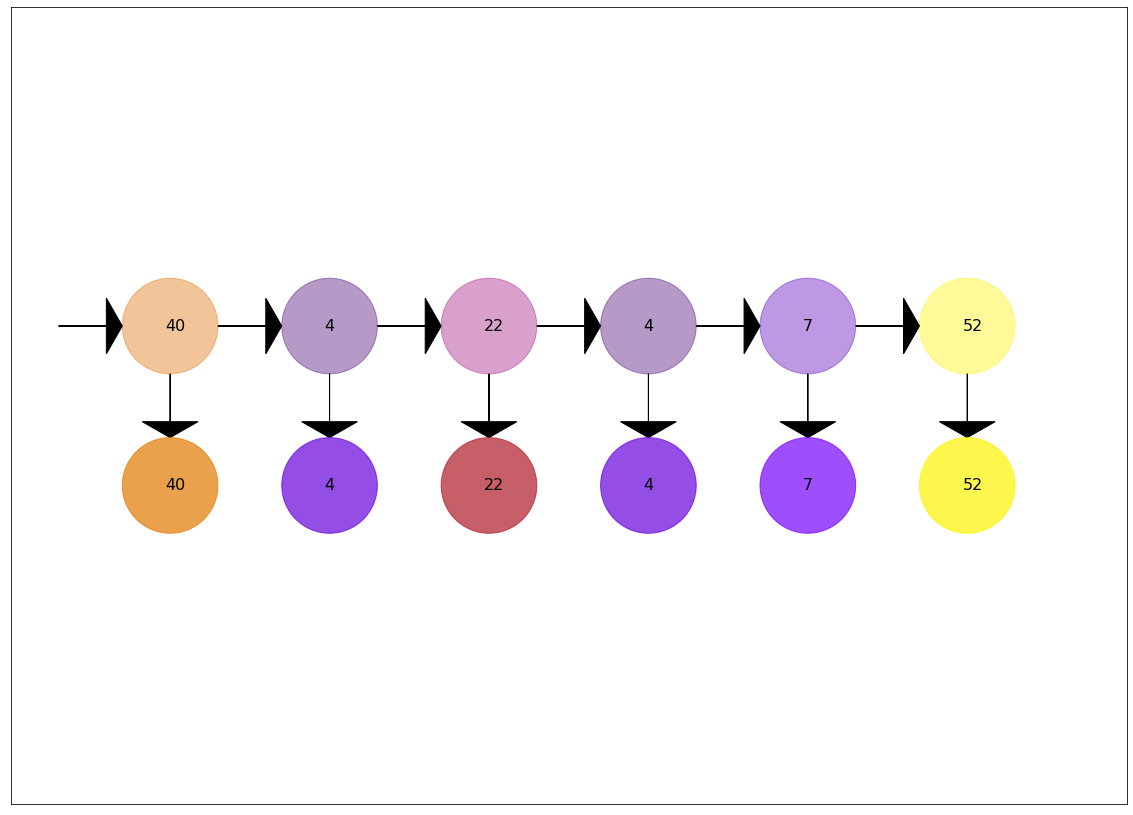

['----', '++--', '+0--', '++--', '++0-', '-00-']


In [24]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pblHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Pass-by left HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))


## Creating pass-by right HMM

In [25]:
pass_by_r_seqs = pb_r_lab_seqs_train

In [26]:
pass_by_r_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_r_seqs]
print(pass_by_r_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pass_by_r_seqs]

[[40, 67, 13, 22, 4, 7, 6, 8, 6, 3, 6, 3, 8, 16, 15], [40, 67, 13, 4, 7, 6, 8, 7, 8, 7, 6, 8, 16, 15, 9], [40, 67, 4, 3, 5, 3, 5], [41, 40, 67, 13, 4, 7, 1, 2, 0, 6], [40, 67, 13, 4, 7, 6, 7], [40, 67, 13, 4, 7, 1], [40, 67, 4, 8, 3, 5, 3, 21, 3, 5, 4]]


[['----',
  '0---',
  '+---',
  '+0--',
  '++--',
  '++0-',
  '++0+',
  '++00',
  '++0+',
  '++-+',
  '++0+',
  '++-+',
  '++00',
  '+-0-',
  '+-0+'],
 ['----',
  '0---',
  '+---',
  '++--',
  '++0-',
  '++0+',
  '++00',
  '++0-',
  '++00',
  '++0-',
  '++0+',
  '++00',
  '+-0-',
  '+-0+',
  '+-++'],
 ['----', '0---', '++--', '++-+', '++-0', '++-+', '++-0'],
 ['---0',
  '----',
  '0---',
  '+---',
  '++--',
  '++0-',
  '+++-',
  '+++0',
  '++++',
  '++0+'],
 ['----', '0---', '+---', '++--', '++0-', '++0+', '++0-'],
 ['----', '0---', '+---', '++--', '++0-', '+++-'],
 ['----',
  '0---',
  '++--',
  '++00',
  '++-+',
  '++-0',
  '++-+',
  '+0-+',
  '++-+',
  '++-0',
  '++--']]

In [27]:
# Create transition matrix from handwritten examples of pass-by QTC-B sequences
# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pass_by_r_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
0
1
2
3
4
0
1
2
3
4
5
6
7
8
9
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.00552486 0.00552486 0.00552486 ... 0.00552486 0.00552486 0.00552486]
 [0.00552486 0.00552486 0.55801105 ... 0.00552486 0.00552486 0.00552486]
 [0.55801105 0.00552486 0.00552486 ... 0.00552486 0.00552486 0.00552486]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]


In [28]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())

# Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in pass_by_r_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

# print(Pi)
# print(Pi.sum())

# Create HMM using the pass-by e.g. parameters
pbrHMM = hmms.DtHMM(A, B, Pi)

# Check pbrHMM params
A, B, Pi = pbrHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

A:
 [[0.00552486 0.00552486 0.00552486 ... 0.00552486 0.00552486 0.00552486]
 [0.00552486 0.00552486 0.55801105 ... 0.00552486 0.00552486 0.00552486]
 [0.55801105 0.00552486 0.00552486 ... 0.00552486 0.00552486 0.00552486]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]
1.0
B:
 [[9.50617284e-01 6.17283951e-04 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 9.50617284e-01 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 9.50617284e-01 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 ...
 [6.17283951e-04 6.17283951e-04 6.17283951e-04 ... 9.50617284e-01
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 6.17283951e-04 ... 6.17283951e-04
  9.50617284e-01 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 6.17283951e-

In [29]:
# draw_transition_matrix(A,"QTC_C_Pass-By-Right_Lab_Egs_Transitions", 0.013)

Pass-by right HMM:


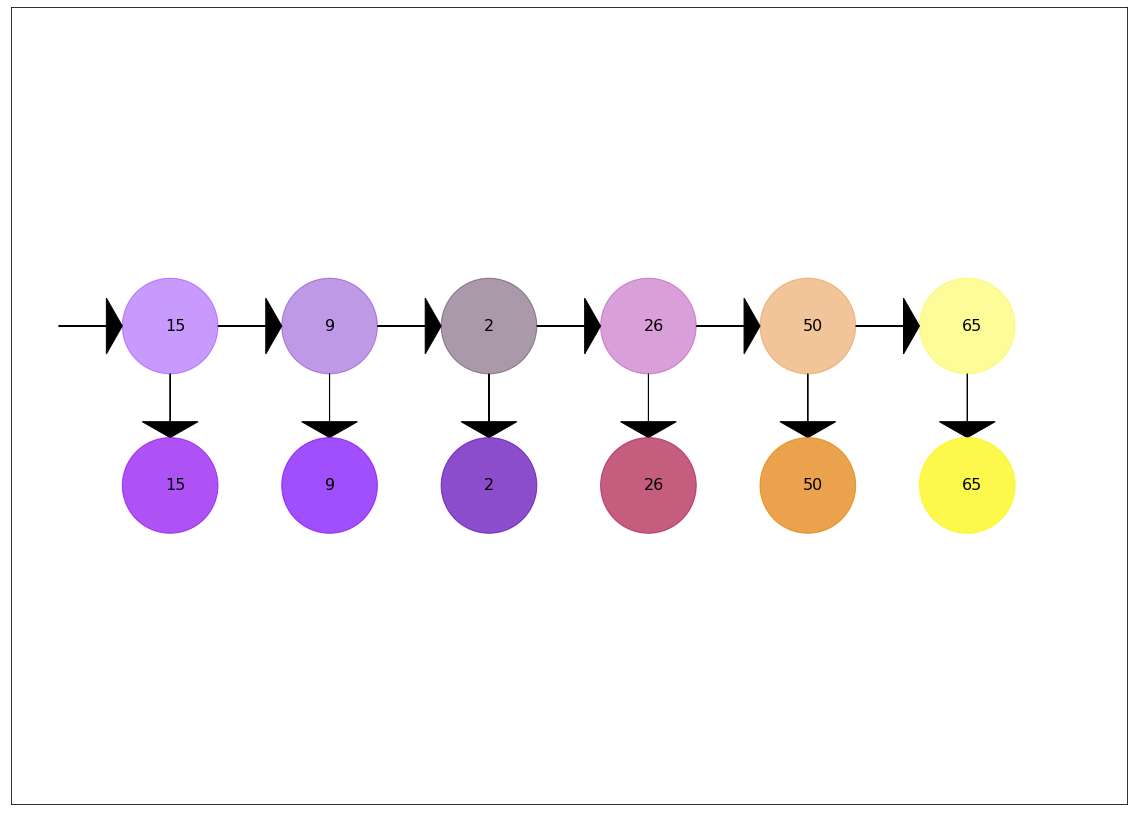

['+-0+', '+-++', '+++0', '+000', '-0-0', '0-+0']


In [30]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pbrHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Pass-by right HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))


## Creating robot overtakes left HMM

In [31]:
rotl_seqs = rotl_lab_seqs_train

In [32]:
rotl_seqs = [list(map(QTC_C_to_num, seq)) for seq in rotl_seqs]
print(rotl_seqs)
[list(map(num_to_QTC_C, seq)) for seq in rotl_seqs]

[[23, 13, 23, 5, 4, 22, 13, 22, 4, 22, 4, 5, 4, 22, 4, 22, 4, 7, 25, 7, 8, 26, 71, 69, 78, 69, 71], [22, 23, 14, 13, 22, 4, 16, 13, 7, 8, 7, 25, 7, 25, 7, 8, 26, 80, 71, 69], [23, 13, 22, 23, 5, 4, 22, 13, 22, 4, 5, 21, 14, 23, 22, 4, 7, 5, 26, 25, 7, 8, 7, 25, 7], [22, 4, 5, 4, 22, 13, 22, 4, 5, 23, 22, 4, 21, 12, 23, 4, 5, 4, 7, 8, 26, 80], [76, 4, 22, 13, 22, 4, 5, 4, 5, 23, 3, 4, 13, 3, 4, 13, 4, 13, 3, 13, 4, 5, 4, 22, 4, 5, 16], [23, 22, 4, 23, 22, 4, 3, 5, 23, 14, 13, 22, 23, 21, 23, 4, 21, 12, 22, 4, 14, 4], [77, 75, 77, 76, 67, 13, 22, 4, 22, 23, 12, 14, 22, 4, 23, 14, 13, 22, 23, 21, 5, 4]]


[['+0-0',
  '+---',
  '+0-0',
  '++-0',
  '++--',
  '+0--',
  '+---',
  '+0--',
  '++--',
  '+0--',
  '++--',
  '++-0',
  '++--',
  '+0--',
  '++--',
  '+0--',
  '++--',
  '++0-',
  '+00-',
  '++0-',
  '++00',
  '+000',
  '0-00',
  '0-0+',
  '000+',
  '0-0+',
  '0-00'],
 ['+0--',
  '+0-0',
  '+--0',
  '+---',
  '+0--',
  '++--',
  '+-0-',
  '+---',
  '++0-',
  '++00',
  '++0-',
  '+00-',
  '++0-',
  '+00-',
  '++0-',
  '++00',
  '+000',
  '0000',
  '0-00',
  '0-0+'],
 ['+0-0',
  '+---',
  '+0--',
  '+0-0',
  '++-0',
  '++--',
  '+0--',
  '+---',
  '+0--',
  '++--',
  '++-0',
  '+0-+',
  '+--0',
  '+0-0',
  '+0--',
  '++--',
  '++0-',
  '++-0',
  '+000',
  '+00-',
  '++0-',
  '++00',
  '++0-',
  '+00-',
  '++0-'],
 ['+0--',
  '++--',
  '++-0',
  '++--',
  '+0--',
  '+---',
  '+0--',
  '++--',
  '++-0',
  '+0-0',
  '+0--',
  '++--',
  '+0-+',
  '+--+',
  '+0-0',
  '++--',
  '++-0',
  '++--',
  '++0-',
  '++00',
  '+000',
  '0000'],
 ['00--',
  '++--',
  '+0--',
  '+---',
  '+0--',
  '++-

In [33]:
# Create transition matrix from handwritten examples of overtake QTC-B sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in rotl_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.00552486 0.00552486 0.00552486 ... 0.00552486 0.00552486 0.00552486]
 [0.01234568 0.01234568 0.01234568 ... 0.0

In [34]:
# creating observation matrix
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in rotl_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
rotlHMM = hmms.DtHMM(A, B, Pi)

# Check rotlHMM params
A, B, Pi = rotlHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[0.00128041 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041
 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041
 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041
 0.00128041 0.00128041 0.00128041 0.00128041 0.25736236 0.38540333
 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041
 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041
 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041
 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041
 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041
 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041
 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041
 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041 0.00128041
 0.00128041 0.00128041 0.00128041 0.00128041 0.12932138 0.12932138
 0.00128041 0.00128041 0.00128041]
0.9999999999999997
A:
 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.0123

In [35]:
A.min()

0.00031436655139893135

In [36]:
# draw_transition_matrix(A, "QTC_C_Robot-Overtakes-Left_Lab_Egs_Transitions", 0.0124)

Robot overtakes left HMM:


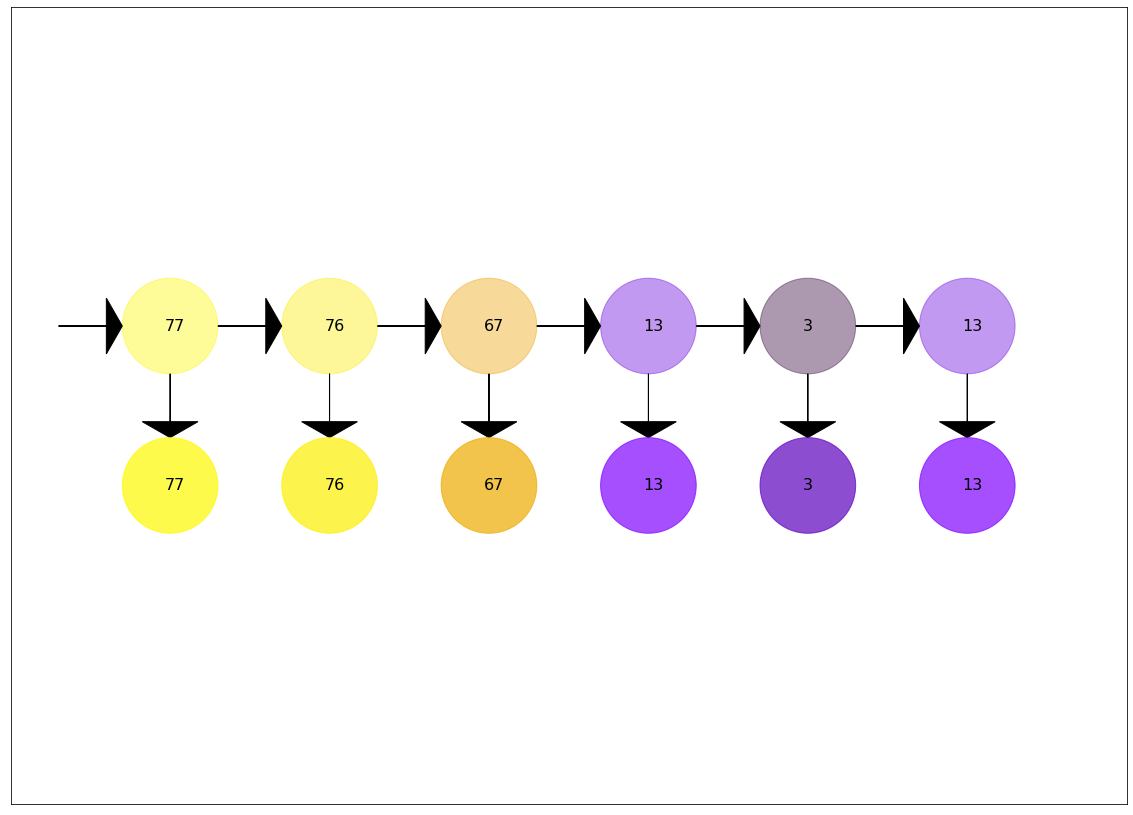

['00-0', '00--', '0---', '+---', '++-+', '+---']


In [37]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = rotlHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Robot overtakes left HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Creating robot overtakes right HMM

In [38]:
rotr_seqs = rotr_lab_seqs_train

In [39]:
rotr_seqs = [list(map(QTC_C_to_num, seq)) for seq in rotr_seqs]
print(rotr_seqs)
[list(map(num_to_QTC_C, seq)) for seq in rotr_seqs]

[[2, 20, 19, 20, 1, 2, 1, 19, 20, 2, 1, 2, 9, 1, 2, 18, 9, 11, 20, 2, 0, 2], [26, 25, 1, 20, 8, 20, 18, 0, 2, 8, 7, 1, 7, 1, 8, 2, 8, 7, 8, 7, 25, 19, 1, 2, 0, 2, 1, 7, 25, 26, 80], [26, 25, 26, 6, 8, 7, 25, 8, 7, 8, 7, 26, 8, 26, 6, 8, 7, 8, 6, 8, 1, 7, 19, 1, 2, 0, 6, 8, 26, 8, 16, 25, 79], [26, 25, 19, 20, 2, 8, 7, 1, 19, 25, 1, 7, 1, 2, 1, 2, 20, 1, 19, 1, 2, 1, 19, 26, 80], [22, 23, 21, 3, 21, 23, 22, 4, 22, 4, 8, 4, 5, 6, 5, 23, 7, 4, 7, 8, 24, 6, 8, 7], [23, 4, 5, 4, 23, 22, 5, 6, 3, 5, 4, 23, 14, 23, 5, 4, 22, 13, 16, 22, 15, 21, 5, 8, 4, 7]]


[['+++0',
  '+0+0',
  '+0+-',
  '+0+0',
  '+++-',
  '+++0',
  '+++-',
  '+0+-',
  '+0+0',
  '+++0',
  '+++-',
  '+++0',
  '+-++',
  '+++-',
  '+++0',
  '+0++',
  '+-++',
  '+-+0',
  '+0+0',
  '+++0',
  '++++',
  '+++0'],
 ['+000',
  '+00-',
  '+++-',
  '+0+0',
  '++00',
  '+0+0',
  '+0++',
  '++++',
  '+++0',
  '++00',
  '++0-',
  '+++-',
  '++0-',
  '+++-',
  '++00',
  '+++0',
  '++00',
  '++0-',
  '++00',
  '++0-',
  '+00-',
  '+0+-',
  '+++-',
  '+++0',
  '++++',
  '+++0',
  '+++-',
  '++0-',
  '+00-',
  '+000',
  '0000'],
 ['+000',
  '+00-',
  '+000',
  '++0+',
  '++00',
  '++0-',
  '+00-',
  '++00',
  '++0-',
  '++00',
  '++0-',
  '+000',
  '++00',
  '+000',
  '++0+',
  '++00',
  '++0-',
  '++00',
  '++0+',
  '++00',
  '+++-',
  '++0-',
  '+0+-',
  '+++-',
  '+++0',
  '++++',
  '++0+',
  '++00',
  '+000',
  '++00',
  '+-0-',
  '+00-',
  '000-'],
 ['+000',
  '+00-',
  '+0+-',
  '+0+0',
  '+++0',
  '++00',
  '++0-',
  '+++-',
  '+0+-',
  '+00-',
  '+++-',
  '++0-',
  '+++-',
  '+++0

In [40]:
# Create transition matrix from handwritten examples of overtake QTC-B sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in rotr_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[2.07900208e-03 2.07900208e-03 6.25779626e-01 ... 2.07900208e-03
  2.07900208e-03 2.07900208e-03]
 [5.31632111e-04 5.31632111e-04 4.25837321e-01 ... 5.31632111e-04
  5.31632111e-04 5.31632111e-04]
 [1.90385832e-01 3.16888046e-01 6.32511069e-04 ... 6.32511069e-04
  6.32511069e-04 6.32511069e-04]
 ...
 [1.23456790e-02 1.23456790e-02 1.23

In [41]:
# creating observation matrix
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in rotr_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
rotrHMM = hmms.DtHMM(A, B, Pi)

# Check rotrHMM params
A, B, Pi = rotrHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[0.00146843 0.00146843 0.14831131 0.00146843 0.00146843 0.00146843
 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843
 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843
 0.00146843 0.00146843 0.00146843 0.00146843 0.14831131 0.14831131
 0.00146843 0.00146843 0.44199706 0.00146843 0.00146843 0.00146843
 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843
 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843
 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843
 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843
 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843
 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843
 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843
 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843 0.00146843
 0.00146843 0.00146843 0.00146843]
1.0000000000000002
A:
 [[2.07900208e-03 2.07900208e-03 6.25779626e-01 ... 2.07900208e-03
 

In [42]:
A.min()

0.0005047955577990913

In [43]:
# draw_transition_matrix(A, "QTC_C_Robot-Overtakes-Right_Lab_Egs_Transitions", 0.0124)

Robot overtakes right HMM:


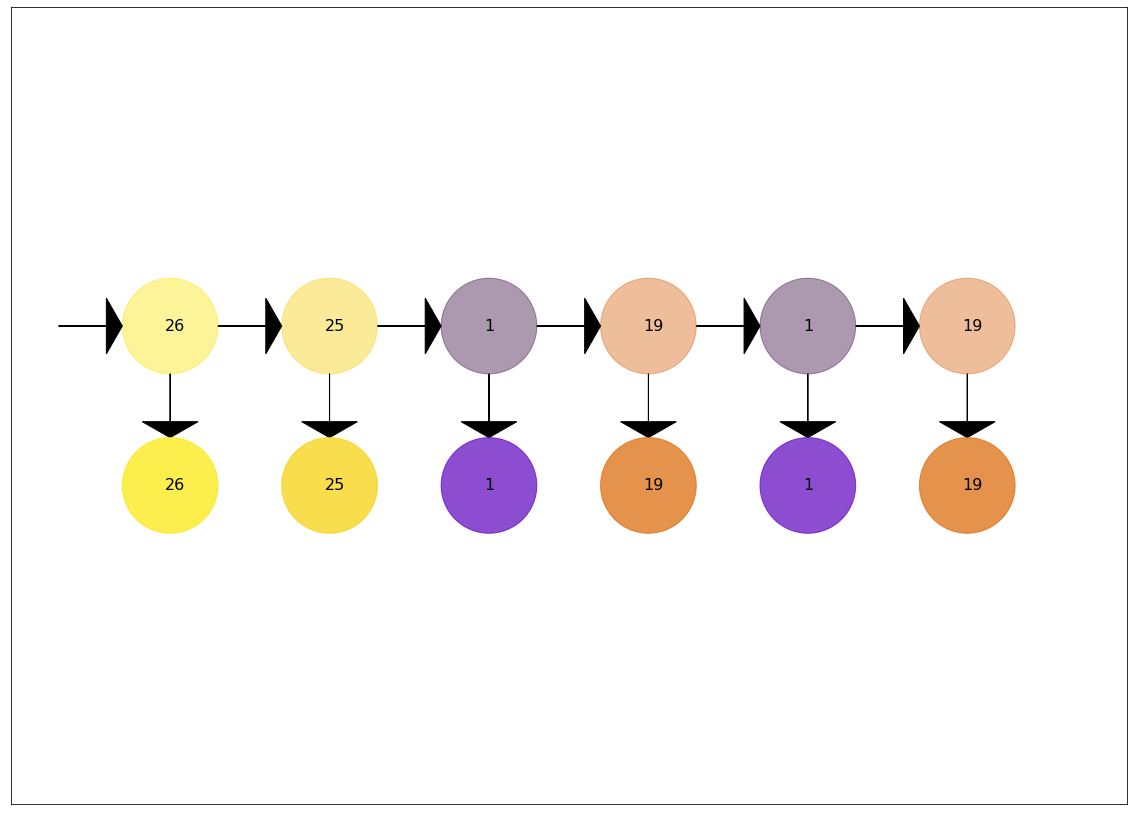

['+000', '+00-', '+++-', '+0+-', '+++-', '+0+-']


In [44]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = rotrHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Robot overtakes right HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Creating path-crossing HMM

In [45]:
pc_seqs = pc_lab_seqs_train

In [46]:
pc_seqs = [list(map(QTC_C_to_num, seq)) for seq in pc_seqs]
print(pc_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pc_seqs]

[[40, 49, 31, 40, 31, 58, 4, 5, 3], [40, 49, 31, 58, 4, 13, 7], [40, 49, 31, 58, 4, 5], [40, 31, 58, 4, 13, 16, 15], [66, 68, 14, 12, 14, 13], [40, 67, 76, 4], [12, 14, 12, 14, 13, 22, 7, 4, 7, 6], [66, 68, 66, 68, 66, 14, 13, 4], [12, 14, 13], [40, 49, 31, 58, 4, 5], [40, 67, 58, 4, 5, 4], [40, 76, 58, 4], [12, 14, 13, 14, 13], [40, 58, 4]]


[['----', '-0--', '-+--', '----', '-+--', '0+--', '++--', '++-0', '++-+'],
 ['----', '-0--', '-+--', '0+--', '++--', '+---', '++0-'],
 ['----', '-0--', '-+--', '0+--', '++--', '++-0'],
 ['----', '-+--', '0+--', '++--', '+---', '+-0-', '+-0+'],
 ['0--+', '0--0', '+--0', '+--+', '+--0', '+---'],
 ['----', '0---', '00--', '++--'],
 ['+--+',
  '+--0',
  '+--+',
  '+--0',
  '+---',
  '+0--',
  '++0-',
  '++--',
  '++0-',
  '++0+'],
 ['0--+', '0--0', '0--+', '0--0', '0--+', '+--0', '+---', '++--'],
 ['+--+', '+--0', '+---'],
 ['----', '-0--', '-+--', '0+--', '++--', '++-0'],
 ['----', '0---', '0+--', '++--', '++-0', '++--'],
 ['----', '00--', '0+--', '++--'],
 ['+--+', '+--0', '+---', '+--0', '+---'],
 ['----', '0+--', '++--']]

In [47]:
# Create transition matrix from handwritten examples of path-crossing QTC_C sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pc_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
7
0
1
2
3
4
5
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
0
1
2
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
0
1
0
1
2
3
4
0
1
2
3
4
0
1
2
0
1
2
3
0
1
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]


In [48]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
Pi = (np.ones((1, N_nodes)))[0]
for seq in pc_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
pcHMM = hmms.DtHMM(A, B, Pi)

# Check otHMM params
A, B, Pi = pcHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[0.00067522 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522
 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522
 0.20324105 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522
 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522
 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522
 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522
 0.00067522 0.00067522 0.00067522 0.00067522 0.60837272 0.00067522
 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522
 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522
 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522
 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522
 0.13571911 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522
 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522 0.00067522
 0.00067522 0.00067522 0.00067522]
1.0
A:
 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234

In [49]:
A.min()

0.0009250693802035154

In [50]:
# draw_transition_matrix(A, "QTC_C_Path_Crossing_Lab_Egs_Transitions", 0.0124)

Path-crossing HMM:


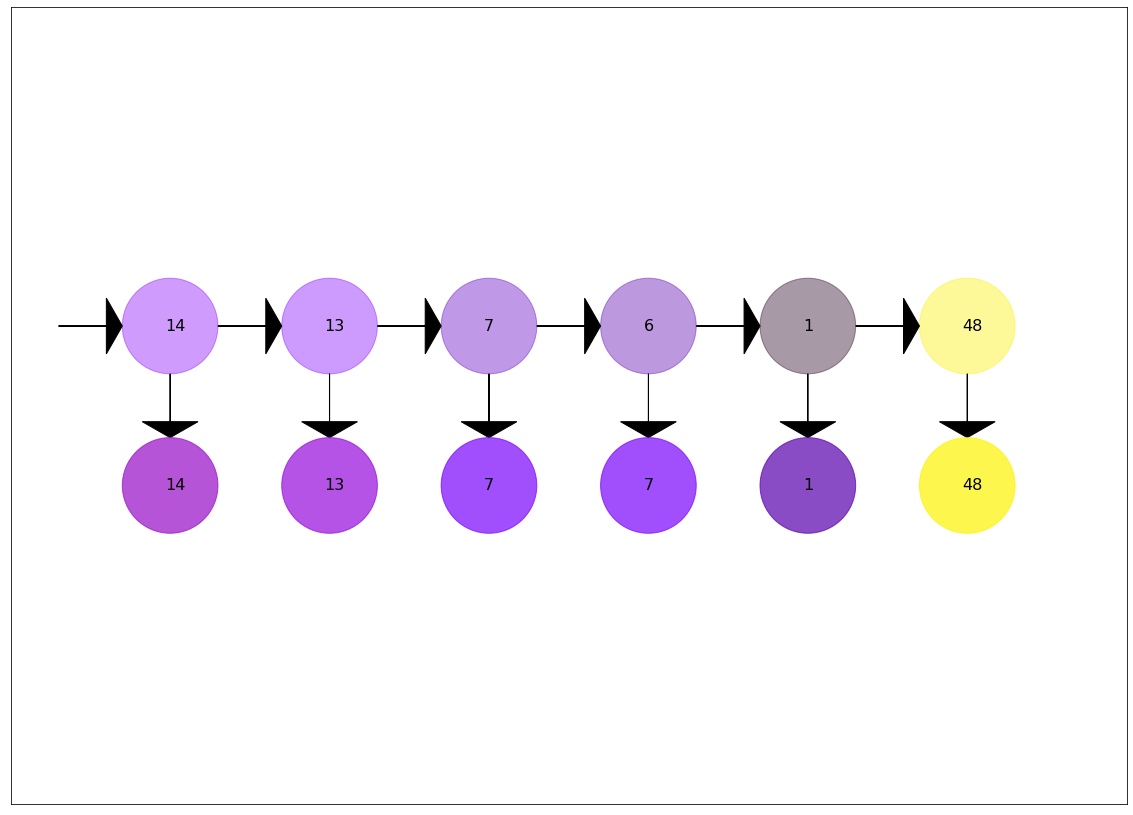

['+--0', '+---', '++0-', '++0+', '+++-', '-0-+']


In [51]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pcHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Path-crossing HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Creating rejections HMM

In [52]:
u_seqs = u_lab_seqs_train

u_seqs = [list(map(QTC_C_to_num, seq)) for seq in u_seqs]
print(u_seqs)
[list(map(num_to_QTC_C, seq)) for seq in u_seqs]

# Create HMM using uniform parameters as a baseline to compare against pass-by
A = np.ones((N_nodes, N_nodes))
print(A.shape)

if rejections_trained:
    # Give frequency based probs to e.g. transitions
    for seq in u_seqs:
        for i in range(0, len(seq) - 1):
            print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)


# Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
Pi = (np.ones((1, N_nodes)))[0]
if rejections_trained:
    for seq in u_seqs:
        Pi[seq[0]] += rejection_init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())


uniform_HMM = hmms.DtHMM(A, B, Pi)

# Check uniform_HMM params
A_uniform, B_uniform, Pi_uniform = uniform_HMM.params
print("A:\n", A_uniform)
for row in A_uniform:
    print(row.sum())
print("B:\n", B_uniform)
for row in B_uniform:
    print(row.sum())
print("Pi:\n", Pi_uniform)
print(Pi_uniform.sum())

[[68, 67, 13, 22, 13, 22, 4, 22, 4, 7, 8, 62, 80], [70, 79, 61, 79, 78], [70, 61, 62, 61], [70, 79, 61, 60, 61, 62], [61], [80], [60, 70, 61, 60]]
(81, 81)
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
0
1
2
0
1
2
3
4
0
1
2
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.00262467 0.00262467 0.00262467 ... 0.26509186 0.00262467 0.00262467]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]
[0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.0113

rejections HMM:


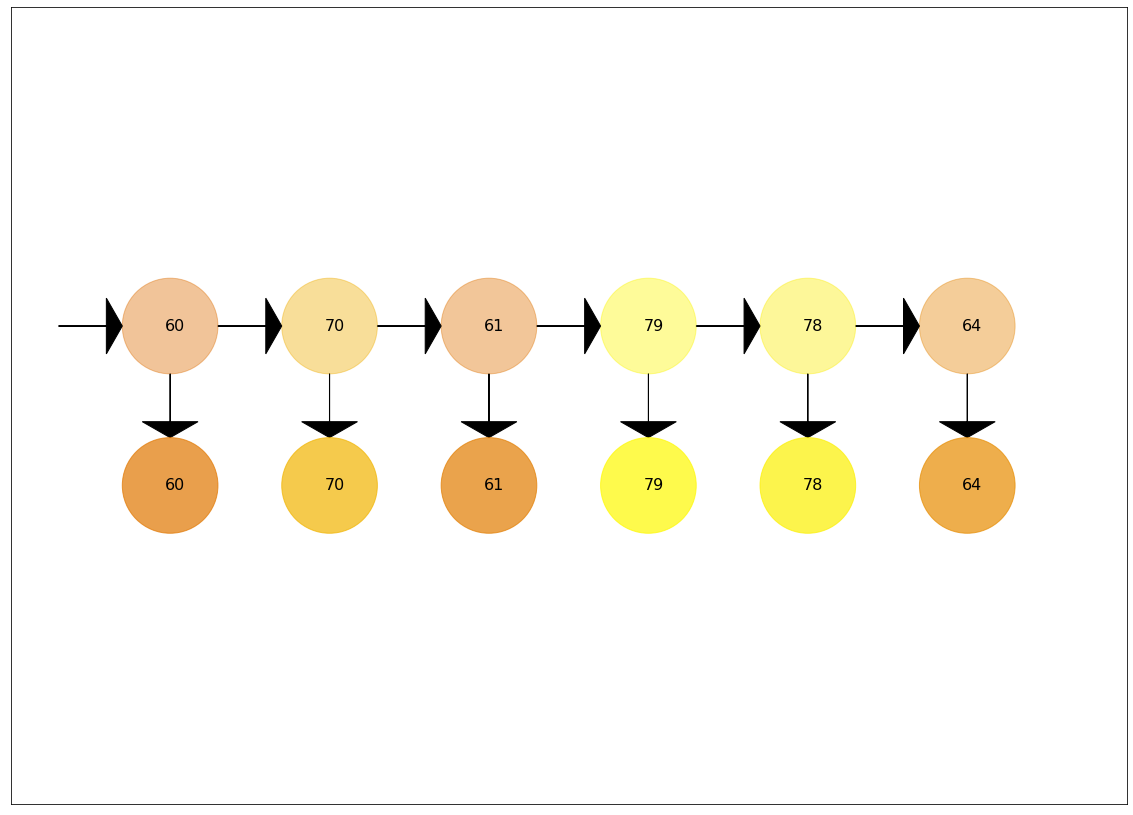

['0+0+', '0-0-', '0+0-', '000-', '000+', '0-+-']


In [53]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = uniform_HMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("rejections HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Classifying HRI situation of QTC<sub>C</sub> sequences generated by rejections HMM

In [54]:
# Generate dataset of both hidden states and emissions sequences from uniform HMM
s_seqs, e_seqs = uniform_HMM.generate_data((len(pass_by_l_seqs), len(pass_by_l_seqs[0])))
e_seqs

print(s_seqs)

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs)
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

[[68 67 13 22  4 22  6]
 [ 0 20 42 45 50  1 67]
 [73 35 23 20 54 46 77]
 [80 35 54 20 60 40 20]
 [70 79 36 19 46 57 31]
 [ 9 71 12 69 65 38 53]
 [ 5 54 47 54 31 18 74]]
-222.35001671020925
The probability of the dataset being generated by the pass-by left model is: 2.720286784459923e-97 .
-221.30251075289186
The probability of the dataset being generated by the pass-by right model is: 7.754266961492808e-97 .
-195.31629171750782
The probability of the dataset being generated by the rejection model is: 1.4969671884377974e-85 .
-226.41713180053085
The probability of the dataset being generated by the robot overtaking left model is: 4.658960738982125e-99 .
-242.41861954224214
The probability of the dataset being generated by the robot overtaking right model is: 5.2351752225924e-106 .
-239.71984023329702
The probability of the dataset being generated by the path-crossing model is: 7.780297146338967e-105 .
Classified as rejection


## Classifying HRI situation of example pass-by left QTC<sub>C</sub> sequences

In [55]:
pass_by_l_seqs = [np.array(seq) for seq in pass_by_l_seqs]

In [56]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pass_by_l_seqs)

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs)
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

-59.52303220594139
The probability of the dataset being generated by the pass-by left model is: 1.4108328614756234e-26 .
-165.05746893403506
The probability of the dataset being generated by the pass-by right model is: 2.0722972230679018e-72 .
-188.43644979033598
The probability of the dataset being generated by the rejection model is: 1.4557596129904933e-82 .
-162.78681138707168
The probability of the dataset being generated by the robot overtaking left model is: 2.0071789233775707e-71 .
-217.56520350741383
The probability of the dataset being generated by the robot overtaking right model is: 3.255612164734138e-95 .
-194.9897498038789
The probability of the dataset being generated by the path-crossing model is: 2.0750455403842843e-85 .
Classified as pass-by left


## Classifying HRI situation of example pass-by right QTC<sub>C</sub> sequences

In [57]:
pass_by_r_seqs = [np.array(seq) for seq in pass_by_r_seqs]

In [58]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pass_by_r_seqs)

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs)
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

-179.53909424550662
The probability of the dataset being generated by the pass-by left model is: 1.0645402417108674e-78 .
-61.506041599325805
The probability of the dataset being generated by the pass-by right model is: 1.9420729072417424e-27 .
-283.25200970796226
The probability of the dataset being generated by the rejection model is: 9.665296822884802e-124 .
-278.56512415720175
The probability of the dataset being generated by the robot overtaking left model is: 1.0488266835004464e-121 .
-265.47937245770635
The probability of the dataset being generated by the robot overtaking right model is: 5.055609048582242e-116 .
-230.1979656311026
The probability of the dataset being generated by the path-crossing model is: 1.0624139903723272e-100 .
Classified as pass-by right


## Classifying HRI situation of example robot overtaking left QTC<sub>C</sub> sequences

In [59]:
rotl_seqs = [np.array(seq) for seq in rotl_seqs]

In [60]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(rotl_seqs)

# print(s_seqs)

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs)
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

-571.6095752448003
The probability of the dataset being generated by the pass-by left model is: 5.663901188562214e-249 .
-672.8211707865273
The probability of the dataset being generated by the pass-by right model is: 6.273042353014216e-293 .
-580.7003151700333
The probability of the dataset being generated by the rejection model is: 6.383479708047715e-253 .
-224.80148107758933
The probability of the dataset being generated by the robot overtaking left model is: 2.3439980406802408e-98 .
-494.92268602536876
The probability of the dataset being generated by the robot overtaking right model is: 1.1423744742115535e-215 .
-674.4982091378789
The probability of the dataset being generated by the path-crossing model is: 1.172599535449381e-293 .
Classified as robot overtaking left


## Classifying HRI situation of example robot overtaking right QTC<sub>C</sub> sequences

In [61]:
rotr_seqs = [np.array(seq) for seq in rotr_seqs]

In [62]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(rotr_seqs)

# print(s_seqs)

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs)
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

-704.3932462096843
The probability of the dataset being generated by the pass-by left model is: 1.2187091764145406e-306 .
-615.5270558783529
The probability of the dataset being generated by the pass-by right model is: 4.786258712140898e-268 .
-698.535709164015
The probability of the dataset being generated by the rejection model is: 4.263792856975297e-304 .
-611.7871835170762
The probability of the dataset being generated by the robot overtaking left model is: 2.0146615566677415e-266 .
-245.60394969810488
The probability of the dataset being generated by the robot overtaking right model is: 2.165508598319883e-107 .
-722.1081614420356
The probability of the dataset being generated by the path-crossing model is: 2.468369369e-314 .
Classified as robot overtaking right


## Classifying HRI situation of example path-crossing QTC<sub>C</sub> sequences

In [63]:
pc_seqs = [np.array(seq) for seq in pc_seqs]

In [64]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pc_seqs)

print(s_seqs)

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs)
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

[[68 67 13 22  4 22  6]
 [ 0 20 42 45 50  1 67]
 [73 35 23 20 54 46 77]
 [80 35 54 20 60 40 20]
 [70 79 36 19 46 57 31]
 [ 9 71 12 69 65 38 53]
 [ 5 54 47 54 31 18 74]]
-328.28820387063985
The probability of the dataset being generated by the pass-by left model is: 2.6683610033679905e-143 .
-335.9660000120496
The probability of the dataset being generated by the pass-by right model is: 1.235435531604992e-146 .
-377.4232449896383
The probability of the dataset being generated by the rejection model is: 1.2222705815292824e-164 .
-345.723031397602
The probability of the dataset being generated by the robot overtaking left model is: 7.151467958391432e-151 .
-388.921745706114
The probability of the dataset being generated by the robot overtaking right model is: 1.2400293018720511e-169 .
-74.93642367984562
The probability of the dataset being generated by the path-crossing model is: 2.854464868559383e-33 .
Classified as path-crossing


## Classifying HRI situation of individual lab QTC<sub>C</sub> sequences

In [65]:
# Get hidden states and emissions sequences from observed sequences
sequence_no = 5
symbol_seqs = [[QTC_C_to_num(qtc) for qtc in u_lab_seqs[i]] for i in range(len(u_lab_seqs))]
e_seqs = np.array([symbol_seqs[sequence_no]])

print(list(map(num_to_QTC_C, s_seqs[0])))

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs)
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

['0--0', '0---', '+---', '+0--', '++--', '+0--', '++0+']
-19.76469813884631
The probability of the dataset being generated by the pass-by left model is: 2.6079584132566637e-09 .
-19.80016356192129
The probability of the dataset being generated by the pass-by right model is: 2.5170869861837395e-09 .
-6.9418941603413025
The probability of the dataset being generated by the rejection model is: 0.0009664372751944115 .
-19.825874775336302
The probability of the dataset being generated by the robot overtaking left model is: 2.4531945216190284e-09 .
-19.705932145482546
The probability of the dataset being generated by the robot overtaking right model is: 2.7658104199372643e-09 .
-20.41525691116212
The probability of the dataset being generated by the path-crossing model is: 1.360713134314864e-09 .
Classified as rejection


## K-fold CV of Classifying HRSI situation of all lab QTC<sub>C</sub> sequences

In [66]:
rotl_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(rotl_lab_seqs):
    rotl_splits.append([train_index, test_index])
    
rotl_splits

rotr_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(rotr_lab_seqs):
    rotr_splits.append([train_index, test_index])
    
rotr_splits

pbl_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(pb_l_lab_seqs):
    pbl_splits.append([train_index, test_index])
    
pbl_splits

pbr_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(pb_r_lab_seqs):
    pbr_splits.append([train_index, test_index])
    
pbr_splits

pc_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(pc_lab_seqs):
    pc_splits.append([train_index, test_index])
    
pc_splits

u_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(u_lab_seqs):
    u_splits.append([train_index, test_index])
    
u_splits

[[array([ 0,  1,  5,  6,  7,  8, 10]), array([2, 3, 4, 9])],
 [array([ 2,  3,  4,  5,  8,  9, 10]), array([0, 1, 6, 7])],
 [array([0, 1, 2, 3, 4, 6, 7, 9]), array([ 5,  8, 10])]]

In [67]:
overall_accs = []
rotl_accs = []
rotr_accs = []
pbl_accs = []
pbr_accs = []
pc_accs = []
u_accs = []
y_true = []
y_pred = []

for k in range(K):    
    rotl_lab_seqs_train = np.array(rotl_lab_seqs)[rotl_splits[k][0]]
    rotl_lab_seqs_val = np.array(rotl_lab_seqs)[rotl_splits[k][1]]
    
    rotr_lab_seqs_train = np.array(rotr_lab_seqs)[rotr_splits[k][0]]
    rotr_lab_seqs_val = np.array(rotr_lab_seqs)[rotr_splits[k][1]]
    
    pb_l_lab_seqs_train = np.array(pb_l_lab_seqs)[pbl_splits[k][0]]
    pb_l_lab_seqs_val = np.array(pb_l_lab_seqs)[pbl_splits[k][1]]
    
    pb_r_lab_seqs_train = np.array(pb_r_lab_seqs)[pbr_splits[k][0]]
    pb_r_lab_seqs_val = np.array(pb_r_lab_seqs)[pbr_splits[k][1]]
    
    pc_lab_seqs_train = np.array(pc_lab_seqs)[pc_splits[k][0]]
    pc_lab_seqs_val = np.array(pc_lab_seqs)[pc_splits[k][1]]
    
    u_lab_seqs_train = np.array(u_lab_seqs)[u_splits[k][0]]
    u_lab_seqs_val = np.array(u_lab_seqs)[u_splits[k][1]]
    
        
    ## Re-build models from training data
    ## Creating pass-by left HMM

    pass_by_l_seqs = pb_l_lab_seqs_train

    pass_by_l_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_l_seqs]
#     print(pass_by_l_seqs)
#     [list(map(num_to_QTC_C, seq)) for seq in pass_by_l_seqs]

    # Create transition matrix from handwritten examples of pass-by QTC-B sequences
    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in pass_by_l_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
    # (.1 / N_nodes) for all observations for numerical stability
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)
    # B = np.eye(N_nodes)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())

    # Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
    # (We may make a stronger assumption here at some point)
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in pass_by_l_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

    # print(Pi)
    # print(Pi.sum())

    # Create HMM using the pass-by e.g. parameters
    pblHMM = hmms.DtHMM(A, B, Pi)

    # Check pblHMM params
    A, B, Pi = pblHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())

#     pass_by_l_seqs = tuple(pass_by_l_seqs)
    pass_by_l_seqs = [np.asarray(seq) for seq in pass_by_l_seqs]
    pass_by_l_seqs = np.asarray(pass_by_l_seqs)
    print(pass_by_l_seqs)
#     pass_by_l_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_l_seqs]

    ## Creating pass-by right HMM

    pass_by_r_seqs = pb_r_lab_seqs_train

    pass_by_r_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_r_seqs]
#     print(pass_by_r_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in pass_by_r_seqs]

    # Create transition matrix from handwritten examples of pass-by QTC-B sequences
    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in pass_by_r_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
    # (.1 / N_nodes) for all observations for numerical stability
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)
    # B = np.eye(N_nodes)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())

    # Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
    # (We may make a stronger assumption here at some point)
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in pass_by_r_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

    # print(Pi)
    # print(Pi.sum())

    # Create HMM using the pass-by e.g. parameters
    pbrHMM = hmms.DtHMM(A, B, Pi)

    # Check pbrHMM params
    A, B, Pi = pbrHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())

    ## Creating robot overtakes left HMM

    rotl_seqs = rotl_lab_seqs_train

    rotl_seqs = [list(map(QTC_C_to_num, seq)) for seq in rotl_seqs]
#     print(rotl_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in rotl_seqs]

    # Create transition matrix from handwritten examples of overtake QTC-B sequences

    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in rotl_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))


    # Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
    # (We may make a stronger assumption here at some point)
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in rotl_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

#     print(Pi)
#     print(Pi.sum())

    # Create HMM using the overtake e.g. parameters
    rotlHMM = hmms.DtHMM(A, B, Pi)

    # Check rotlHMM params
    A, B, Pi = rotlHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())

    ## Creating robot overtakes right HMM

    rotr_seqs = rotr_lab_seqs_train

    rotr_seqs = [list(map(QTC_C_to_num, seq)) for seq in rotr_seqs]
#     print(rotr_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in rotr_seqs]

    # Create transition matrix from handwritten examples of overtake QTC-B sequences

    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in rotr_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))


    # Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
    # (We may make a stronger assumption here at some point)
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in rotr_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

#     print(Pi)
#     print(Pi.sum())

    # Create HMM using the overtake e.g. parameters
    rotrHMM = hmms.DtHMM(A, B, Pi)

    # Check rotrHMM params
    A, B, Pi = rotrHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())

    ## Creating path-crossing HMM

    pc_seqs = pc_lab_seqs_train

    pc_seqs = [list(map(QTC_C_to_num, seq)) for seq in pc_seqs]
#     print(pc_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in pc_seqs]

    # Create transition matrix from handwritten examples of path-crossing QTC_C sequences

    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in pc_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
    # (.1 / N_nodes) for all observations for numerical stability
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)
    # B = np.eye(N_nodes)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))


    # Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in pc_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

#     print(Pi)
#     print(Pi.sum())

    # Create HMM using the path-crossing e.g. parameters
    pcHMM = hmms.DtHMM(A, B, Pi)

    # Check pcHMM params
    A, B, Pi = pcHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())

    ## Creating rejections HMM

    u_seqs = u_lab_seqs_train

    u_seqs = [list(map(QTC_C_to_num, seq)) for seq in u_seqs]
#     print(u_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in u_seqs]

    # Create HMM using uniform parameters as a baseline to compare against pass-by
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    if rejections_trained:
        # Give frequency based probs to e.g. transitions
        for seq in u_seqs:
            for i in range(0, len(seq) - 1):
#                 print(i)
                A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)


    # Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
    Pi = (np.ones((1, N_nodes)))[0]
    if rejections_trained:
        for seq in u_seqs:
            Pi[seq[0]] += rejection_init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

#     print(Pi)
#     print(Pi.sum())

    uniform_HMM = hmms.DtHMM(A, B, Pi)

    # Check uniform_HMM params
    A_uniform, B_uniform, Pi_uniform = uniform_HMM.params
#     print("A:\n", A_uniform)
#     for row in A_uniform:
#         print(row.sum())
#     print("B:\n", B_uniform)
#     for row in B_uniform:
#         print(row.sum())
#     print("Pi:\n", Pi_uniform)
#     print(Pi_uniform.sum())

#     if rejections_trained:
#         u_seqs = [np.asarray(seq) for seq in u_seqs]
#         u_seqs = np.asarray(u_seqs)
#         uniform_HMM.baum_welch(u_seqs, bw_epochs)
        
    
    
    # Get correct count and accuracy of pass-by left classifications
    pb_l_correct = 0
    for pb_l_seq in pb_l_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pb_l_seq]]
        e_seqs = np.array(symbol_seqs)

        ll_pb_l = pblHMM.data_estimate(e_seqs) - pbl_negative_bias
    #     print(ll_pb_l)
        prob_pb_l = np.exp(ll_pb_l)

    #     print("The probability of the dataset being generated by the pass-by left model is:", \
    #           prob_pb_l, ".")

        ll_pb_r = pbrHMM.data_estimate(e_seqs) - pbr_negative_bias
    #     print(ll_pb_r)
        prob_pb_r = np.exp(ll_pb_r)

    #     print("The probability of the dataset being generated by the pass-by right model is:", \
    #           prob_pb_r, ".")

        ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
    #     print(ll_uniform)
        prob_uniform = np.exp(ll_uniform)

    #     print("The probability of the dataset being generated by the rejection model is:", \
    #           prob_uniform, ".")

        ll_rotl = rotlHMM.data_estimate(e_seqs) - rotl_negative_bias
    #     print(ll_rotl)
        prob_rotl = np.exp(ll_rotl)

    #     print("The probability of the dataset being generated by the robot overtaking left model is:", \
    #           prob_rotl, ".")

        ll_rotr = rotrHMM.data_estimate(e_seqs) - rotr_negative_bias
    #     print(ll_rotr)
        prob_rotr = np.exp(ll_rotr)

    #     print("The probability of the dataset being generated by the robot overtaking right model is:", \
    #           prob_rotr, ".")

        ll_pc = pcHMM.data_estimate(e_seqs) - pc_negative_bias
    #     print(ll_pc)
        prob_pc = np.exp(ll_pc)

    #     print("The probability of the dataset being generated by the path-crossing model is:", \
    #           prob_pc, ".")

        classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
        class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
#         print("Classified as", classes[class_id])

        correct_class_id = 0
        y_true.append(correct_class_id)
        y_pred.append(class_id)
        
        if class_id == correct_class_id:
            pb_l_correct += 1
            
        pb_l_acc = pb_l_correct/len(pb_l_lab_seqs_val)*100
#     print("Pass-by left classifications are " + str(pb_l_acc) + "% accurate" )

    # Get correct count and accuracy of pass-by classifications
    pb_r_correct = 0
    for pb_r_seq in pb_r_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pb_r_seq]]
        e_seqs = np.array(symbol_seqs)

        ll_pb_l = pblHMM.data_estimate(e_seqs) - pbl_negative_bias
    #     print(ll_pb_r)
        prob_pb_l = np.exp(ll_pb_l)

    #     print("The probability of the dataset being generated by the pass-by left model is:", \
    #           prob_pb_r, ".")

        ll_pb_r = pbrHMM.data_estimate(e_seqs) - pbr_negative_bias
    #     print(ll_pb_r)
        prob_pb_r = np.exp(ll_pb_r)

    #     print("The probability of the dataset being generated by the pass-by right model is:", \
    #           prob_pb_r, ".")

        ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
    #     print(ll_uniform)
        prob_uniform = np.exp(ll_uniform)

    #     print("The probability of the dataset being generated by the rejection model is:", \
    #           prob_uniform, ".")

        ll_rotl = rotlHMM.data_estimate(e_seqs) - rotl_negative_bias
    #     print(ll_rotl)
        prob_rotl = np.exp(ll_rotl)

    #     print("The probability of the dataset being generated by the robot overtaking left model is:", \
    #           prob_rotl, ".")

        ll_rotr = rotrHMM.data_estimate(e_seqs) - rotr_negative_bias
    #     print(ll_rotr)
        prob_rotr = np.exp(ll_rotr)

    #     print("The probability of the dataset being generated by the robot overtaking right model is:", \
    #           prob_rotr, ".")

        ll_pc = pcHMM.data_estimate(e_seqs) - pc_negative_bias
    #     print(ll_pc)
        prob_pc = np.exp(ll_pc)

    #     print("The probability of the dataset being generated by the path-crossing model is:", \
    #           prob_pc, ".")

        classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
        class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
#         print("Classified as", classes[class_id])

        correct_class_id = 1
        y_true.append(correct_class_id)
        y_pred.append(class_id)
    
        if class_id == correct_class_id:
            pb_r_correct += 1
            
        pb_r_acc = (pb_r_correct/len(pb_r_lab_seqs_val))*100
#     print("Pass-by right classifications are " + str(pb_r_acc) + "% accurate" )

    # Get correct count and accuracy of robot overtaking left classifications
    rotl_correct = 0
    for rotl_seq in rotl_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in rotl_seq]]
        e_seqs = np.array(symbol_seqs)

        ll_pb_l = pblHMM.data_estimate(e_seqs) - pbl_negative_bias
    #     print(ll_pb_r)
        prob_pb_l = np.exp(ll_pb_l)

    #     print("The probability of the dataset being generated by the pass-by left model is:", \
    #           prob_pb_r, ".")

        ll_pb_r = pbrHMM.data_estimate(e_seqs) - pbr_negative_bias
    #     print(ll_pb_r)
        prob_pb_r = np.exp(ll_pb_r)

    #     print("The probability of the dataset being generated by the pass-by right model is:", \
    #           prob_pb_r, ".")

        ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
    #     print(ll_uniform)
        prob_uniform = np.exp(ll_uniform)

    #     print("The probability of the dataset being generated by the rejection model is:", \
    #           prob_uniform, ".")

        ll_rotl = rotlHMM.data_estimate(e_seqs) - rotl_negative_bias
    #     print(ll_rotl)
        prob_rotl = np.exp(ll_rotl)

    #     print("The probability of the dataset being generated by the robot overtaking left model is:", \
    #           prob_rotl, ".")

        ll_rotr = rotrHMM.data_estimate(e_seqs) - rotr_negative_bias
    #     print(ll_rotr)
        prob_rotr = np.exp(ll_rotr)

    #     print("The probability of the dataset being generated by the robot overtaking right model is:", \
    #           prob_rotr, ".")

        ll_pc = pcHMM.data_estimate(e_seqs) - pc_negative_bias
    #     print(ll_pc)
        prob_pc = np.exp(ll_pc)

    #     print("The probability of the dataset being generated by the path-crossing model is:", \
    #           prob_pc, ".")

        classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
        class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
#         print("Classified as", classes[class_id])

        correct_class_id = 2
        y_true.append(correct_class_id)
        y_pred.append(class_id)
    
        if class_id == correct_class_id:
            rotl_correct += 1
            
        rotl_acc = (rotl_correct/len(rotl_lab_seqs_val))*100
#     print("Robot overtaking left classifications are " + str(rotl_acc) + "% accurate" )

    # Get correct count and accuracy of robot overtaking right classifications
    rotr_correct = 0
    for rotr_seq in rotr_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in rotr_seq]]
        e_seqs = np.array(symbol_seqs)

        ll_pb_l = pblHMM.data_estimate(e_seqs) - pbl_negative_bias
    #     print(ll_pb_r)
        prob_pb_l = np.exp(ll_pb_l)

    #     print("The probability of the dataset being generated by the pass-by left model is:", \
    #           prob_pb_r, ".")

        ll_pb_r = pbrHMM.data_estimate(e_seqs) - pbr_negative_bias
    #     print(ll_pb_r)
        prob_pb_r = np.exp(ll_pb_r)

    #     print("The probability of the dataset being generated by the pass-by right model is:", \
    #           prob_pb_r, ".")

        ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
    #     print(ll_uniform)
        prob_uniform = np.exp(ll_uniform)

    #     print("The probability of the dataset being generated by the rejection model is:", \
    #           prob_uniform, ".")

        ll_rotl = rotlHMM.data_estimate(e_seqs) - rotl_negative_bias
    #     print(ll_rotl)
        prob_rotl = np.exp(ll_rotl)

    #     print("The probability of the dataset being generated by the robot overtaking left model is:", \
    #           prob_rotl, ".")

        ll_rotr = rotrHMM.data_estimate(e_seqs) - rotr_negative_bias
    #     print(ll_rotr)
        prob_rotr = np.exp(ll_rotr)

    #     print("The probability of the dataset being generated by the robot overtaking right model is:", \
    #           prob_rotr, ".")

        ll_pc = pcHMM.data_estimate(e_seqs) - pc_negative_bias
    #     print(ll_pc)
        prob_pc = np.exp(ll_pc)

    #     print("The probability of the dataset being generated by the path-crossing model is:", \
    #           prob_pc, ".")

        classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
        class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
#         print("Classified as", classes[class_id])

        correct_class_id = 3
        y_true.append(correct_class_id)
        y_pred.append(class_id)
    
        if class_id == correct_class_id:
            rotr_correct += 1
            
        rotr_acc = (rotr_correct/len(rotr_lab_seqs_val))*100
#     print("Robot overtaking right classifications are " + str(rotr_acc) + "% accurate" )

    # Get correct count and accuracy of path-crossing classifications
    pcs_correct = 0
    for pc_seq in pc_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pc_seq]]
        e_seqs = np.array(symbol_seqs)

        ll_pb_l = pblHMM.data_estimate(e_seqs) - pbl_negative_bias
    #     print(ll_pb_r)
        prob_pb_l = np.exp(ll_pb_l)

    #     print("The probability of the dataset being generated by the pass-by left model is:", \
    #           prob_pb_r, ".")

        ll_pb_r = pbrHMM.data_estimate(e_seqs) - pbr_negative_bias
    #     print(ll_pb_r)
        prob_pb_r = np.exp(ll_pb_r)

    #     print("The probability of the dataset being generated by the pass-by right model is:", \
    #           prob_pb_r, ".")

        ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
    #     print(ll_uniform)
        prob_uniform = np.exp(ll_uniform)

    #     print("The probability of the dataset being generated by the rejection model is:", \
    #           prob_uniform, ".")

        ll_rotl = rotlHMM.data_estimate(e_seqs) - rotl_negative_bias
    #     print(ll_rotl)
        prob_rotl = np.exp(ll_rotl)

    #     print("The probability of the dataset being generated by the robot overtaking left model is:", \
    #           prob_rotl, ".")

        ll_rotr = rotrHMM.data_estimate(e_seqs) - rotr_negative_bias
    #     print(ll_rotr)
        prob_rotr = np.exp(ll_rotr)

    #     print("The probability of the dataset being generated by the robot overtaking right model is:", \
    #           prob_rotr, ".")

        ll_pc = pcHMM.data_estimate(e_seqs) - pc_negative_bias
    #     print(ll_pc)
        prob_pc = np.exp(ll_pc)

    #     print("The probability of the dataset being generated by the path-crossing model is:", \
    #           prob_pc, ".")

        classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
        class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
#         print("Classified as", classes[class_id])

        correct_class_id = 4
        y_true.append(correct_class_id)
        y_pred.append(class_id)
    
        if class_id == correct_class_id:
            pcs_correct += 1
            
        pc_acc = (pcs_correct/len(pc_lab_seqs_val))*100
#     print("Path-crossing classifications are " + str(pc_acc) + "% accurate" )

    # Get correct count and accuracy of rejections
    us_correct = 0
    for u_seq in u_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in u_seq]]
        e_seqs = np.array(symbol_seqs)

        ll_pb_l = pblHMM.data_estimate(e_seqs) - pbl_negative_bias
    #     print(ll_pb_r)
        prob_pb_l = np.exp(ll_pb_l)

    #     print("The probability of the dataset being generated by the pass-by left model is:", \
    #           prob_pb_r, ".")

        ll_pb_r = pbrHMM.data_estimate(e_seqs) - pbr_negative_bias
    #     print(ll_pb_r)
        prob_pb_r = np.exp(ll_pb_r)

    #     print("The probability of the dataset being generated by the pass-by right model is:", \
    #           prob_pb_r, ".")

        ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
    #     print(ll_uniform)
        prob_uniform = np.exp(ll_uniform)

    #     print("The probability of the dataset being generated by the rejection model is:", \
    #           prob_uniform, ".")

        ll_rotl = rotlHMM.data_estimate(e_seqs) - rotl_negative_bias
    #     print(ll_rotl)
        prob_rotl = np.exp(ll_rotl)

    #     print("The probability of the dataset being generated by the robot overtaking left model is:", \
    #           prob_rotl, ".")

        ll_rotr = rotrHMM.data_estimate(e_seqs) - rotr_negative_bias
    #     print(ll_rotr)
        prob_rotr = np.exp(ll_rotr)

    #     print("The probability of the dataset being generated by the robot overtaking right model is:", \
    #           prob_rotr, ".")

        ll_pc = pcHMM.data_estimate(e_seqs) - pc_negative_bias
    #     print(ll_pc)
        prob_pc = np.exp(ll_pc)

    #     print("The probability of the dataset being generated by the path-crossing model is:", \
    #           prob_pc, ".")

        classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
        class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
#         print("Classified as", classes[class_id])

        correct_class_id = 5
        y_true.append(correct_class_id)
        y_pred.append(class_id)
    
        if class_id == correct_class_id:
            us_correct += 1

    # Rejections recall
    rTPs = us_correct
    rFNs = len(u_lab_seqs_val) - us_correct
    # rFPs = 0 # As accuracy in all other classes is 100%
    recall = rTPs / (rTPs + rFNs)
    # precision = rTPs / (rTPs + rFPs)
    
    u_acc = us_correct/len(u_lab_seqs_val)*100

#     print("Rejections FN rate: " + str((rFNs/len(u_lab_seqs_val)*100)) + "%")
#     print("Rejections accuracy: " + str(u_acc) + "%" )
#     print("Rejection recall:", str(recall * 100) + "%")
    # print("Rejection precision:", str(precision * 100) + "%")

    total = len(pb_l_lab_seqs_val) + len(pb_r_lab_seqs_val) + len(rotl_lab_seqs_val) + len(rotl_lab_seqs_val) + len(pc_lab_seqs_val)
    total_correct = pb_l_correct + pb_r_correct + rotr_correct + rotl_correct + pcs_correct

    overall_acc = (total_correct/total)*100
    print("k", k+1, "/", K)
    print("\nOverall accuracy (excluding rejections): " + str(overall_acc) + "%")
    print("Robot overtaking left TPR: " + str(np.mean(rotl_acc)) + "%")
    print("Robot overtaking right TPR: " + str(np.mean(rotr_acc)) + "%")
    print("Pass-by left TPR: " + str(np.mean(pb_l_acc)) + "%")
    print("Pass-by right TPR: " + str(np.mean(pb_r_acc)) + "%")
    print("Path-crossing TPR: " + str(np.mean(pc_acc)) + "%")
    print("Rejection TPR: " + str(np.mean(u_acc)) + "%\n")
    
    overall_accs.append(overall_acc)
    rotl_accs.append(rotl_acc)
    rotr_accs.append(rotr_acc)
    pbl_accs.append(pb_l_acc)
    pbr_accs.append(pb_r_acc)
    pc_accs.append(pc_acc)
    u_accs.append(u_acc)
    
    if k == 2:
        pblHMM.save_params("pblHMM_k_3_study")
        pbrHMM.save_params("pbrHMM_k_3_study")
        rotlHMM.save_params("rotlHMM_k_3_study")
        rotrHMM.save_params("rotrHMM_k_3_study")
        pcHMM.save_params("pcHMM_k_3_study")
        uniform_HMM.save_params("uniform_HMM_k_3_study")


[array([13, 22,  4,  7,  1, 10, 11]) array([67, 13, 22,  4,  7, 16, 15])
 array([67, 13,  4,  7, 16,  8]) array([40, 67,  4,  7])
 array([13, 22,  4,  7])
 array([23, 22,  4, 13,  4, 13,  4, 22,  4, 13,  4, 13,  4, 13,  4, 13, 22,
        4])
 array([40,  4,  5,  3,  4,  3,  5,  4, 12,  4])]
k 1 / 3

Overall accuracy (excluding rejections): 82.6086956521739%
Robot overtaking left TPR: 100.0%
Robot overtaking right TPR: 75.0%
Pass-by left TPR: 50.0%
Pass-by right TPR: 100.0%
Path-crossing TPR: 85.71428571428571%
Rejection TPR: 75.0%

[array([67, 13, 22,  4,  7,  1]) array([67, 13,  4,  7,  1])
 array([40, 67, 58,  4, 13, 16]) array([67, 13,  4,  7, 16,  8])
 array([23, 22,  4, 13,  4, 13,  4, 22,  4, 13,  4, 13,  4, 13,  4, 13, 22,
        4])
 array([40, 67, 76, 58,  4, 13, 16, 15])
 array([40,  4,  5,  3,  4,  3,  5,  4, 12,  4])]
k 2 / 3

Overall accuracy (excluding rejections): 65.21739130434783%
Robot overtaking left TPR: 75.0%
Robot overtaking right TPR: 100.0%
Pass-by left TPR: 2

In [68]:
print("K-fold CV results:")
print("Overall accuracy: " + str(np.mean(overall_accs)) + "%")
print("Robot overtaking left TPR: " + str(np.mean(rotl_accs)) + "%")
print("Robot overtaking right TPR: " + str(np.mean(rotr_accs)) + "%")
print("Pass-by left TPR: " + str(np.mean(pbl_accs)) + "%")
print("Pass-by right TPR: " + str(np.mean(pbr_accs)) + "%")
print("Path-crossing TPR: " + str(np.mean(pc_accs)) + "%")
print("Rejection TPR: " + str(np.mean(u_accs)) + "%")


K-fold CV results:
Overall accuracy: 80.85430968726163%
Robot overtaking left TPR: 91.66666666666667%
Robot overtaking right TPR: 91.66666666666667%
Pass-by left TPR: 47.22222222222222%
Pass-by right TPR: 91.66666666666667%
Path-crossing TPR: 85.71428571428571%
Rejection TPR: 83.33333333333333%


In [69]:
cm = confusion_matrix(y_true, y_pred)

In [70]:
df_cm = pd.DataFrame(cm, range(6), range(6))
df_cm.columns = classes
df_cm.index = classes
df_cm

,pass-by left,pass-by right,robot overtaking left,robot overtaking right,path-crossing,rejection
pass-by left,5,1,0,0,3,2
pass-by right,1,10,0,0,0,0
robot overtaking left,0,0,10,1,0,0
robot overtaking right,0,0,1,9,0,0
path-crossing,1,1,0,0,18,1
rejection,0,0,2,0,0,9


/home/loz/QTC_Trajectory_HMMs/from_bags/confusion_matrix_pretty_print.py:167: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/loz/QTC_Trajectory_HMMs/from_bags/confusion_matrix_pretty_print.py:168: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/loz/QTC_Trajectory_HMMs/from_bags/confusion_matrix_pretty_print.py:170: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/loz/QTC_Trajectory_HMMs/from_bags/confusion_matrix_pretty_print.py:171: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = Fa

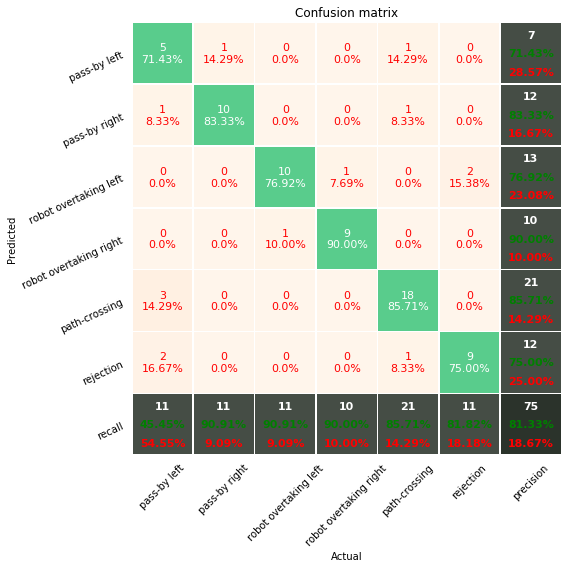

In [71]:
# From MATLAB plotconfusion docs (which inspired this confusion matrix plotting module):
# The column on the far right of the plot shows the percentages of all the examples predicted to belong to each
# class that are correctly and incorrectly classified. These metrics are often called the precision 
# (or positive predictive value) and false discovery rate, respectively. The row at the bottom of the plot shows
# the percentages of all the examples belonging to each class that are correctly and incorrectly classified. 
# These metrics are often called the recall (or true positive rate) and false negative rate, respectively.
# The cell in the bottom right of the plot shows the overall accuracy.
pretty_plot_confusion_matrix(df_cm, show_null_values=2)